In [2]:
!pip install torch_geometric
!pip install biopython
!pip install networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 91.4 MB/s eta 0:00:00


In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import requests
import networkx as nx
from scipy.spatial.distance import euclidean
from Bio.PDB import PDBParser, PDBList
from torch_geometric.nn import GCNConv, GraphNorm, global_mean_pool

from torch.utils.data import Dataset


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
class DeltaDDGDataset(Dataset):
    def __init__(self, all_results):
        self.all_results = all_results

    def __len__(self):
        return len(self.all_results)

    def __getitem__(self, idx):
        return self.all_results[idx]

    def save(self, path):
        data = {
            'all_results': self.all_results,
        }
        torch.save(data, path)

    @classmethod
    def load(cls, path):
        data = torch.load(path, weights_only=False)
        obj = cls.__new__(cls)
        obj.all_results = data['all_results']
        return obj

In [5]:
class ProteinGNNEncoder(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = GCNConv(in_dim,    hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, hidden_dim)

        self.norm1 = GraphNorm(hidden_dim)
        self.norm2 = GraphNorm(hidden_dim)
        self.norm3 = GraphNorm(hidden_dim)
        self.norm4 = GraphNorm(hidden_dim)

        self.project = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index, batch):
        x0 = F.relu(self.norm1(self.conv1(x, edge_index)))

        x1 = F.relu(self.norm2(self.conv2(x0, edge_index))) + x0

        x2 = F.relu(self.norm3(self.conv3(x1, edge_index))) + x1

        x3 = F.relu(self.norm4(self.conv4(x2, edge_index))) + x2

        h = global_mean_pool(x3, batch)

        return self.project(h)

In [6]:
class DeltaDDGPredictor(nn.Module):
    def __init__(self, encoder, embed_dim):
        super().__init__()
        self.encoder = encoder
        self.regressor = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.3), #new 0.2
            nn.Linear(embed_dim * 2, embed_dim),
            nn.ReLU(),
            nn.Dropout(0.3),#new
            nn.Linear(embed_dim, embed_dim // 2), #new
            nn.ReLU(), #new
            nn.Dropout(0.3),#new
            # nn.Linear(embed_dim, 1)
            nn.Linear(embed_dim // 2, 1) #new
)

    def forward(self, data_wt, data_mut):
        h_wt = self.encoder(data_wt.x, data_wt.edge_index, data_wt.batch)
        h_mut = self.encoder(data_mut.x, data_mut.edge_index, data_mut.batch)
        h_diff = h_mut - h_wt
        return self.regressor(h_diff).squeeze()

In [7]:
def train(model, optimizer, criterion, dataloader, device):
    model.train()
    total_loss = 0
    for data_wt, data_mut, ddg, _ in tqdm(dataloader):
        data_wt, data_mut, ddg = data_wt.to(device), data_mut.to(device), ddg.to(device)
        optimizer.zero_grad()
        pred = model(data_wt, data_mut)
        loss = criterion(pred, ddg)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * ddg.size(0)
    return total_loss / len(dataloader.dataset)


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data_wt, data_mut, ddg, _ in dataloader:
            data_wt, data_mut, ddg = data_wt.to(device), data_mut.to(device), ddg.to(device)
            pred = model(data_wt, data_mut)
            loss = criterion(pred, ddg)
            total_loss += loss.item() * ddg.size(0)
            all_preds.extend(pred.view(-1).cpu().numpy())
            all_targets.extend(ddg.view(-1).cpu().numpy())


    mse = criterion(torch.tensor(all_preds), torch.tensor(all_targets)).item()

    return total_loss / len(dataloader.dataset), mse

# Load PKL files from saved Train and Val Datasets

In [11]:
#load the data from saved files

# train_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/official_train_set.pkl")
# val_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/official_val_set.pkl")

train_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/BMI_707_Project/707_Files_for_Colab/train_dataset_yuh.pkl")
val_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/BMI_707_Project/707_Files_for_Colab/val_dataset_yuh.pkl")#, weights_only=False)
test_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/BMI_707_Project/707_Files_for_Colab/test_dataset_yuh.pkl")#, weights_only=False)

#convert to dataloader object for training

batch_size = 16
train_loader_official = DataLoader(train_dataset_loaded, batch_size=batch_size, shuffle=True)
val_loader_official = DataLoader(val_dataset_loaded, batch_size=batch_size)
test_loader_official = DataLoader(test_dataset_loaded, batch_size=batch_size)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [12]:
next(iter(train_loader_official))

[DataBatch(x=[4204, 20], edge_index=[2, 35012], pos=[4204, 3], batch=[4204], ptr=[17]),
 DataBatch(x=[4204, 20], edge_index=[2, 35558], pos=[4204, 3], batch=[4204], ptr=[17]),
 tensor([ 1.9500,  2.1000, -0.7000,  3.4400, -0.3000,  0.3000,  1.2300,  0.0000,
         -3.2000,  0.1000, -0.0600,  1.0400,  1.5000,  1.4000,  0.6800,  3.1000]),
 {'experiment_id': ['VB02649',
   'PT002851',
   'VB05284',
   'VB02649',
   'VB02649',
   'PT000073',
   'VB02649',
   'VB01478',
   'VB06183',
   'VB02370',
   'VB02649',
   'VB02649',
   'VB01898',
   'VB02649',
   'VB02649',
   'PT004946'],
  'protein_name': ['Immunoglobulin G-binding protein G',
   'Thermonuclease',
   'Polyubiquitin-C',
   'Fatty acid-binding protein, heart',
   'Tryptophan synthase alpha chain',
   'Ribonuclease',
   'Guanyl-specific ribonuclease T1',
   'Thermonuclease',
   'Ribonuclease HI',
   'Thermonuclease',
   'Fibroblast growth factor 1',
   'Immunoglobulin G-binding protein G',
   'Ribonuclease',
   'Guanyl-specific rib

In [13]:
train_dataset_loaded.__getitem__(0)

(Data(x=[163, 20], edge_index=[2, 1510], pos=[163, 3]),
 Data(x=[163, 20], edge_index=[2, 1470], pos=[163, 3]),
 0.26,
 {'experiment_id': 'PT025185',
  'protein_name': 'Peptidyl-prolyl cis-trans isomerase NIMA-interacting 1',
  'uniprot_id': 'Q13526',
  'pdb_id': '1PIN|1PIN',
  'chain': 'A',
  'position': 22,
  'wild_type': 'V',
  'mutation': 'A',
  'ddG': 0.26,
  'sequence': 'MADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGNSSSGGKNGQGEPARVRCSHLLVKHSQSRRPSSWRQEKITRTKEEALELINGYIQKIKSGEEDFESLASQFSDCSSAKARGDLGAFSRGQMQKPFEDASFALRTGEMSGPVFTDSGIHIILRTE',
  'is_in_catalytic_pocket': False,
  'is_essential': False,
  'mt_sequence': 'MADEEKLPPGWEKRMSRSSGRAYYFNHITNASQWERPSGNSSSGGKNGQGEPARVRCSHLLVKHSQSRRPSSWRQEKITRTKEEALELINGYIQKIKSGEEDFESLASQFSDCSSAKARGDLGAFSRGQMQKPFEDASFALRTGEMSGPVFTDSGIHIILRTE'})

In [14]:
##### Training Block

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import math
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = ProteinGNNEncoder(in_dim=20, hidden_dim=256, out_dim=128)
model   = DeltaDDGPredictor(encoder, embed_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

train_losses = []
val_losses = []
val_mse_scores = []
#train_rmse_scores = []

best_val_loss = float("inf")

best_model_path = "structure_only_best_model.pt"


# Training loop
for epoch in range(10):
    # Training
    model.train()
    train_loss = train(model, optimizer, criterion, train_loader_official, device)
    train_losses.append(train_loss)
    #train_rmse_scores.append(math.sqrt(train_loss))
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

    # Validation
    val_loss, val_mse = evaluate(model, val_loader_official, criterion, device)
    val_losses.append(val_loss)
    val_mse_scores.append(val_mse)
    val_rmse = math.sqrt(val_mse)
    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}")

    # Save best model
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_model = copy.deepcopy(model)
      torch.save(best_model.state_dict(), best_model_path)
      print(f"✅ Saved new best model at epoch {epoch+1} (Val Loss: {val_loss:.4f})")

100%|██████████| 189/189 [00:09<00:00, 20.13it/s]


Epoch 1, Train Loss: 3.7904
Epoch 1, Val Loss: 3.0584, MSE: 3.0584, RMSE: 1.7488
✅ Saved new best model at epoch 1 (Val Loss: 3.0584)


100%|██████████| 189/189 [00:07<00:00, 23.92it/s]


Epoch 2, Train Loss: 2.9859
Epoch 2, Val Loss: 2.7710, MSE: 2.7710, RMSE: 1.6646
✅ Saved new best model at epoch 2 (Val Loss: 2.7710)


100%|██████████| 189/189 [00:08<00:00, 23.61it/s]


Epoch 3, Train Loss: 2.6593
Epoch 3, Val Loss: 2.6200, MSE: 2.6200, RMSE: 1.6187
✅ Saved new best model at epoch 3 (Val Loss: 2.6200)


100%|██████████| 189/189 [00:07<00:00, 23.80it/s]


Epoch 4, Train Loss: 2.4655
Epoch 4, Val Loss: 2.5427, MSE: 2.5427, RMSE: 1.5946
✅ Saved new best model at epoch 4 (Val Loss: 2.5427)


100%|██████████| 189/189 [00:08<00:00, 23.57it/s]


Epoch 5, Train Loss: 2.2546
Epoch 5, Val Loss: 2.5044, MSE: 2.5044, RMSE: 1.5825
✅ Saved new best model at epoch 5 (Val Loss: 2.5044)


100%|██████████| 189/189 [00:08<00:00, 23.50it/s]


Epoch 6, Train Loss: 2.1577
Epoch 6, Val Loss: 2.4167, MSE: 2.4167, RMSE: 1.5546
✅ Saved new best model at epoch 6 (Val Loss: 2.4167)


100%|██████████| 189/189 [00:08<00:00, 23.43it/s]


Epoch 7, Train Loss: 2.0876
Epoch 7, Val Loss: 2.4176, MSE: 2.4176, RMSE: 1.5549


100%|██████████| 189/189 [00:08<00:00, 23.18it/s]


Epoch 8, Train Loss: 1.9788
Epoch 8, Val Loss: 2.3702, MSE: 2.3702, RMSE: 1.5396
✅ Saved new best model at epoch 8 (Val Loss: 2.3702)


100%|██████████| 189/189 [00:08<00:00, 23.39it/s]


Epoch 9, Train Loss: 1.8740
Epoch 9, Val Loss: 2.3947, MSE: 2.3947, RMSE: 1.5475


100%|██████████| 189/189 [00:08<00:00, 23.38it/s]


Epoch 10, Train Loss: 1.8702
Epoch 10, Val Loss: 2.3139, MSE: 2.3139, RMSE: 1.5212
✅ Saved new best model at epoch 10 (Val Loss: 2.3139)


📊 Test MSE:  2.5204
📊 Test RMSE: 1.5876
📊 Test MAE:  1.1575
📊 Test R²:   0.2620


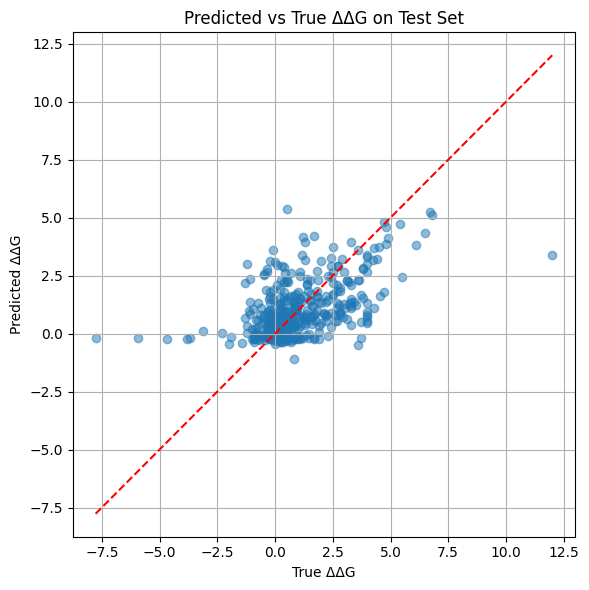

In [15]:
import torch
import numpy as np
import math
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Ensure we're in evaluation mode
best_model.eval()

# Run on test set
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in test_loader_official:
        # Unpack inputs and labels — adjust based on your dataset format
        # Assuming batch is a tuple (graph, features, label, metadata_dict)
        graphs, features, labels, _ = batch
        graphs = graphs.to(device)
        features = features.to(device)
        labels = labels.to(device)

        outputs = best_model(graphs, features)
        all_preds.extend(outputs.cpu().numpy().flatten())
        all_targets.extend(labels.cpu().numpy().flatten())

# Metrics
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
mse = mean_squared_error(all_targets, all_preds)
rmse = math.sqrt(mse)
mae = mean_absolute_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print(f"📊 Test MSE:  {mse:.4f}")
print(f"📊 Test RMSE: {rmse:.4f}")
print(f"📊 Test MAE:  {mae:.4f}")
print(f"📊 Test R²:   {r2:.4f}")

# Plot: predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(all_targets, all_preds, alpha=0.5)
plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--')
plt.xlabel('True ΔΔG')
plt.ylabel('Predicted ΔΔG')
plt.title('Predicted vs True ΔΔG on Test Set')
plt.grid(True)
plt.tight_layout()
plt.show()


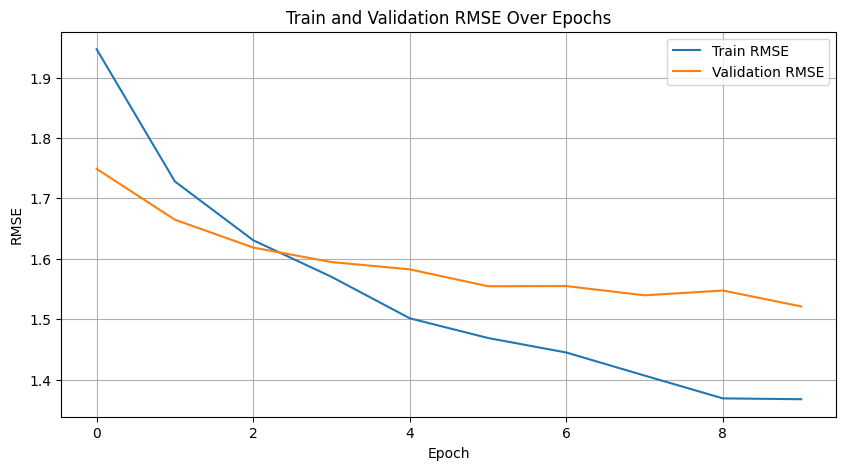

In [16]:
##### Plot RMSE for Train and Validation Sets

import numpy as np

train_rmse_scores = [np.sqrt(loss) for loss in train_losses]
val_rmse_scores = [np.sqrt(mse) for mse in val_mse_scores]

plt.figure(figsize=(10, 5))
plt.plot(train_rmse_scores, label='Train RMSE')
plt.plot(val_rmse_scores, label='Validation RMSE')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Train and Validation RMSE Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
##### Save Performance Data (to plot performances of all 3 models together)
import pandas as pd
import numpy as np

# assemble into a DataFrame
df_GNN__model_official_10_epochs_MSE = pd.DataFrame({
    'epoch': np.arange(1, len(train_rmse_scores) + 1),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_rmse': train_rmse_scores,
    'val_rmse': val_rmse_scores,
    'val_mse': val_mse_scores,
})

# save as CSV
df_GNN__model_official_10_epochs_MSE.to_csv('GNN_model_10_epochs_MSE', index=False)

Pearson r = 0.550 (p=3.7e-31)
Spearman ρ = 0.502
R² = 0.295


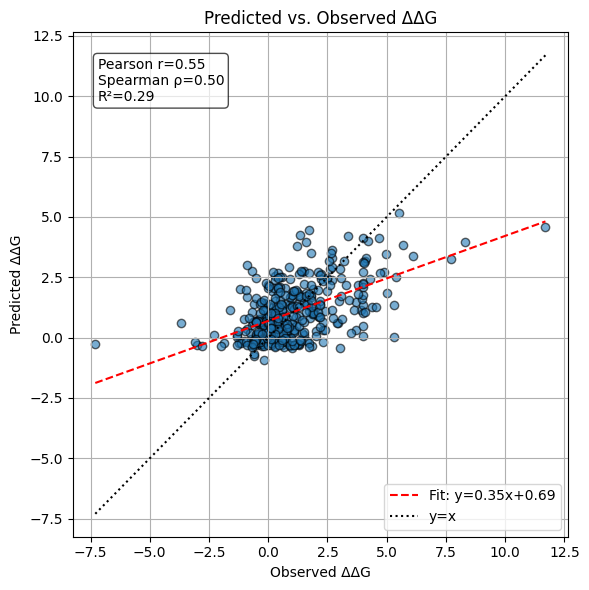

In [19]:
##### Correlations Plot

import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 1) Gather preds & targets
preds, targets = [], []
model.eval()
with torch.no_grad():
    for data_wt, data_mut, ddg, _ in val_loader_official:
        ddg = ddg.to(device)
        out = model(data_wt.to(device), data_mut.to(device))

        # Convert to numpy, flatten, then to list
        p = out.detach().cpu().numpy().flatten().tolist()
        t = ddg.detach().cpu().numpy().flatten().tolist()

        preds.extend(p)
        targets.extend(t)

preds   = np.array(preds)
targets = np.array(targets)

# 2) Compute metrics
pearson_r, pearson_p   = pearsonr(targets, preds)
spearman_rho, _        = spearmanr(targets, preds)
r2                     = r2_score(targets, preds)

print(f"Pearson r = {pearson_r:.3f} (p={pearson_p:.1e})")
print(f"Spearman ρ = {spearman_rho:.3f}")
print(f"R² = {r2:.3f}")

# 3) Plot with best‐fit
m, b = np.polyfit(targets, preds, 1)
x_line = np.linspace(targets.min(), targets.max(), 100)

plt.figure(figsize=(6,6))
plt.scatter(targets, preds, alpha=0.6, edgecolor='k')
plt.plot(x_line, m*x_line + b, 'r--', label=f'Fit: y={m:.2f}x+{b:.2f}')
plt.plot(x_line, x_line, 'k:', label='y=x')
plt.xlabel("Observed ΔΔG")
plt.ylabel("Predicted ΔΔG")
plt.title("Predicted vs. Observed ΔΔG")
plt.legend(loc="best")
plt.text(0.05, 0.95,
         f"Pearson r={pearson_r:.2f}\nSpearman ρ={spearman_rho:.2f}\nR²={r2:.2f}",
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
plt.grid(True)
plt.tight_layout()
plt.show()

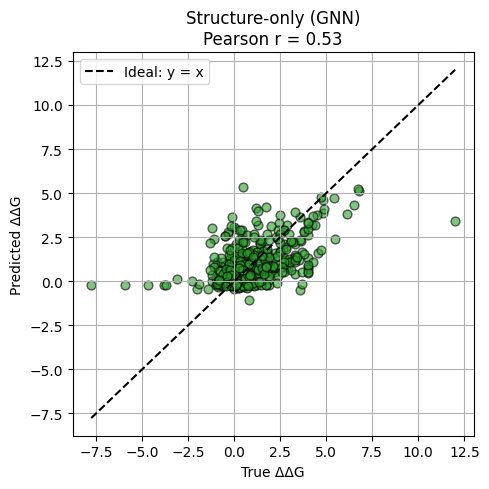

In [20]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# 1) Gather predictions and targets
preds, targets = [], []
best_model.eval()
with torch.no_grad():
    for data_wt, data_mut, ddg, _ in test_loader_official:
        data_wt, data_mut, ddg = data_wt.to(device), data_mut.to(device), ddg.to(device)
        out = best_model(data_wt, data_mut)
        preds.extend(out.cpu().numpy().flatten())
        targets.extend(ddg.cpu().numpy().flatten())

preds = np.array(preds)
targets = np.array(targets)

# 2) Pearson correlation only
pearson_r, _ = pearsonr(targets, preds)

# 3) Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(targets, preds, alpha=0.6, color='#2ca02c', edgecolor='k', s=40)  # green
ax.plot([min(targets), max(targets)], [min(targets), max(targets)], 'k--', label='Ideal: y = x')
ax.set_xlabel('True ΔΔG')
ax.set_ylabel('Predicted ΔΔG')
ax.set_title('Structure-only (GNN)\nPearson r = {:.2f}'.format(pearson_r))
ax.legend()
ax.grid(True)
ax.set_ylim(min(targets)-1, max(targets)+1)
ax.set_xlim(min(targets)-1, max(targets)+1)
plt.tight_layout()
plt.show()
